# Final Frontier

By Shay Altshue & Yvonne King

Quick Notebook Reference

1. Project Plan
2. Acquire Data
3. Prepare Data
4. Exploration
5. Modeling
6. Conclusions

## Project Plan

**Acquisition, Prep, and Initial Exploration**
> - Collect all file
> - Create a dataframe using pandas for each file
> - Clean and prepare the data to perform aggregations and merge each dataframe together
> - Remove/repair erroneous data
> - Look at shape of data

**Exploration**
- Answer the folowing qustion
> some questions

**Main Hypotheses**
- $H_0$: Space flight has not improved in safety and reliability over time, and continous to have a significant risk of failure.
- $H_a$: As technology has improved over time, so has the safety and reliability of space flight.

Our assumption before starting this project is that space flight has significantly improved in terms of the reliability of a launch since the start of space missions back in the '50s. 
Now we'll work through the data to test that hypothesis.

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Hypothesis testing
from math import sqrt
from scipy import stats

import src.wrangle
import src.features
import src.preprocessing

## Wrangle

- The ```wrangle.py``` file has all the functions to call in our data and handles the following:
    - Handled any null values by replacing them with zero
    - Set the date/time column to be the Index
    - Created a Unique ID for each space Mission by combining the company name with original index number
    - Renamed Columns
    - Created numerical codes for mission_status
    - Created country column by extracted the information from the location column

In [2]:
#bring in complete dataframe
df = src.wrangle.get_space_data()

In [3]:
#take a peek at the data
df.sample(5)

,company_name,location,rocket_type,rocket_status,mission_cost,mission_status,year,month,country
date_time,,,,,,,,,
1973-09-06 10:40:00+00:00,RVSN USSR,"Site 41/1, Plesetsk Cosmodrome, Russia",Voskhod | Cosmos 584,retired,0,Success,1973,9,Russia
2002-05-28 08:14:00+00:00,VKS RF,"Site 132/1, Plesetsk Cosmodrome, Russia",Cosmos-3M (11K65M) | Cosmos 2389,retired,0,Success,2002,5,Russia
2011-10-31 21:58:00+00:00,CASC,"Site 901 (SLS-1), Jiuquan Satellite Launch Cen...",Long March 2F/G | Shenzhou 8,active,0,Success,2011,10,China
1972-03-01 11:15:00+00:00,RVSN USSR,"Site 43/4, Plesetsk Cosmodrome, Russia",Vostok-2M | Cosmos 476,retired,0,Success,1972,3,Russia
2019-07-22 09:13:00+00:00,ISRO,"Second Launch Pad, Satish Dhawan Space Centre,...",GSLV Mk III | Chandrayaan-2 lunar mission,active,62.0,Success,2019,7,India


In [4]:
#look at the shape of the data
print(f'Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}')

Number of rows: 4324, Number of columns: 9


In [5]:
#look at data types and counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4324 entries, 2020-08-07 05:12:00+00:00 to 1957-10-04 19:28:00+00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   company_name    4324 non-null   object
 1   location        4324 non-null   object
 2   rocket_type     4324 non-null   object
 3   rocket_status   4324 non-null   object
 4   mission_cost    4324 non-null   object
 5   mission_status  4324 non-null   object
 6   year            4324 non-null   int64 
 7   month           4324 non-null   int64 
 8   country         4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 337.8+ KB


In [6]:
#make sure there are no nulls
df.isnull().sum()

company_name      0
location          0
rocket_type       0
rocket_status     0
mission_cost      0
mission_status    0
year              0
month             0
country           0
dtype: int64

# Add Features

Our target variable, whether or not a mission succeeds or fails, should be the mission_status field. However...

In [7]:
df.mission_status.value_counts()

Success              3879
Failure               339
Partial Failure       102
Prelaunch Failure       4
Name: mission_status, dtype: int64

We want a binary outcome (success vs failure), so we'll create a new feature that aggregates the failures into a single result

In [8]:
df = src.features.mission_result(df)

In [9]:
df.mission_result.value_counts()

1    3879
0     445
Name: mission_result, dtype: int64

> Note: This new feature is already encoded (1: success, 0: failure) 

In [10]:
# Verify there's no missing values in the new feature
df.mission_result.isna().sum()

0

# Exploration

## Has the reliability and safety of space travel gone up over time? 

> To answer this, let's first take a look at the percentage of success/failure in each decade 

In [25]:
decade = 10 * (df['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'

In [36]:
# percentage of successful vs failed missions for each decade
perc_success = df.groupby([decade])['mission_result'].apply(lambda x: x.sum() / len(x))

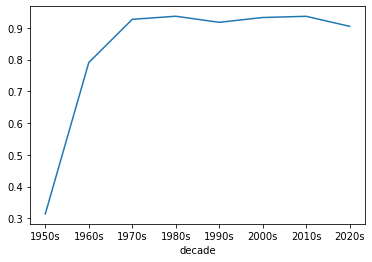

In [45]:
perc_success.plot()

> So we can confirm there has been an increase in safety and reliability of space missions since the 50's.

# Modeling

## Preprocessing the Data

In [ ]:
# Split and encode the data
train, test = src.preprocessing.preprocesses_data_for_modeling(df)

In [ ]:
print('train size:', train.shape)
print('test size:', test.shape)

In [ ]:
X = ['company_name', 'location', 'rocket_type']
y = 'mission_result'

In [ ]:
X_train, y_train = train[X], train[y]
X_test, y_test = test[X], test[y]

## Models

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(random_state=123)
log.fit(X_train, y_train)
train_score = log.score(X_train, y_train)
test_score = log.score(X_test, y_test)

In [ ]:
print('train accuracy: {:.2f} \ntest accuracy:  {:.2f}'.format(train_score, test_score))

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3, random_state=123)
tree.fit(X_train, y_train)

In [ ]:
train_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)

In [ ]:
print('train accuracy: {:.2f} \ntest accuracy:  {:.2f}'.format(train_score, test_score))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=123)
forest.fit(X_train, y_train)

In [ ]:
train_score = forest.score(X_train, y_train)
test_score = forest.score(X_test, y_test)

In [ ]:
print('train accuracy: {:.2f} \ntest accuracy:  {:.2f}'.format(train_score, test_score))

## K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

In [ ]:
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

In [ ]:
print('train accuracy: {:.2f} \ntest accuracy:  {:.2f}'.format(train_score, test_score))